In [1]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime
from fund.fund import Fund
from pricer.pricer import Pricer as pricer_list
from ranker.ranker import Ranker as ranker_list
from classifier.classifier import Classifier as classifier_list
from portfolio.aportfolio import APortfolio

from analysis.quarterly_analysis import QuarterlyAnalysis as quarterly_analysis
from analysis.weekly_analysis import WeeklyAnalysis as weekly_analysis

## risk and return class imports
from returns.products import Products as returns_products_class


from fund.fund import Fund
## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
backtest_start_date = datetime(2016,1,1)
backtest_end_date  = datetime(2023,1,1)
current_start_date = datetime(2023,1,1)

In [3]:
market = Market()

In [4]:
portfolio = APortfolio(pricer_list.QUARTERLY_STOCK_FINANCIAL
                       ,classifier_list.QUARTERLY_STOCK_FINANCIAL_CLASSIFIER
                       ,ranker_list.QUARTERLY_STOCK_EARNINGS_RANKER)
portfolio_ii = APortfolio(pricer_list.WEEKLY_STOCK_SPECULATION
                          ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
                          ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolio_iii = APortfolio(pricer_list.WEEKLY_STOCK_ROLLING
                           ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
                          ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolio_iv = APortfolio(pricer_list.WEEKLY_STOCK_WINDOW
                          ,classifier_list.WEEKLY_STOCK_SPECULATION_CLASSIFIER
                          ,ranker_list.WEEKLY_STOCK_ROLLING_RANKER)
portfolios = [portfolio,portfolio_ii,portfolio_iii,portfolio_iv]
fund = Fund(portfolios,backtest_start_date,backtest_end_date,current_start_date)
fund.initialize_portfolios()

In [5]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [6]:
tyields = returns_products_class.tyields()
bench_returns = returns_products_class.spy_bench()

In [7]:
trades = []
for portfolio in fund.portfolios:
    portfolio.db.connect()
    trade = portfolio.db.retrieve("historical_trades")
    trade["positions"] = portfolio.pricer_class.positions / 2
    trade["portfolio"] = portfolio.name
    trade["pricer_timeframe"] = portfolio.pricer_class.time_horizon_class.naming_convention
    trades.append(trade)
    portfolio.db.disconnect()

In [8]:
t = pd.concat(trades)

In [9]:
t

,year,quarter,ticker,quarterly_delta,quarterly_delta_sign,short_returns,returns,position,actual_returns,value,ceiling,classification,rank,short,positions,portfolio,pricer_timeframe,week,weekly_delta,weekly_delta_sign
0,2016,1.0,FAST,0.842146,-1.0,0.711797,1.288203,0,0.711797,True,True,True,True,True,10.0,qsf_qsfc_qser_b_r,quarter,NaN,NaN,NaN
1,2016,2.0,COP,0.447705,-1.0,0.882425,1.117575,0,0.882425,True,True,True,True,True,10.0,qsf_qsfc_qser_b_r,quarter,NaN,NaN,NaN
2,2016,3.0,IBM,0.186911,-1.0,0.930099,1.069901,0,0.930099,True,True,True,True,True,10.0,qsf_qsfc_qser_b_r,quarter,NaN,NaN,NaN
3,2016,4.0,CVX,0.242248,1.0,1.160305,1.160305,0,1.160305,True,True,True,True,True,10.0,qsf_qsfc_qser_b_r,quarter,NaN,NaN,NaN
4,2017,1.0,WMB,0.765865,-1.0,1.049557,0.950443,0,1.049557,True,True,True,True,True,10.0,qsf_qsfc_qser_b_r,quarter,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96203,2022,NaN,MDT,NaN,NaN,0.992757,0.992757,19,0.992757,False,False,False,False,False,10.0,wsw_wssc_wsrr_b_r,week,48.0,0.053902,1.0
96204,2022,NaN,TFC,NaN,NaN,1.005624,1.005624,19,1.005624,False,False,False,False,False,10.0,wsw_wssc_wsrr_b_r,week,49.0,0.100257,1.0
96205,2022,NaN,COST,NaN,NaN,0.976420,0.976420,19,0.976420,False,False,False,False,False,10.0,wsw_wssc_wsrr_b_r,week,50.0,0.089217,1.0
96206,2022,NaN,VRTX,NaN,NaN,0.990405,0.990405,19,0.990405,False,False,False,False,False,10.0,wsw_wssc_wsrr_b_r,week,51.0,0.083312,1.0


In [10]:
nonindex_columns = [
"year"
,"quarter"
,"week"
,"ticker"
,"quarterly_delta_sign"
,"quarterly_delta"
,"weekly_delta_sign"
,"weekly_delta"
,"short_returns"
,"returns"
,"floored_returns"
,"actual_returns"
,"position"
,"projected_quarterly_return"
,"positions"] 

In [11]:
indexers = []
indexer = []
for col in t.columns:
    if col not in nonindex_columns:
        indexers.append(list(t[col].unique()))
        indexer.append(col)
stuff = t[indexer].to_dict("records")
parameters = [dict(t) for t in {tuple(d.items()) for d in stuff}]

In [12]:
indexer

['value',
 'ceiling',
 'classification',
 'rank',
 'short',
 'portfolio',
 'pricer_timeframe']

In [13]:
analysis = []
for parameter in parameters:
    try:
        ledger = t.sort_values(["year",parameter["pricer_timeframe"]]).copy()
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        positions = int(ledger["positions"].mean())
        anas = weekly_analysis if parameter["pricer_timeframe"] == "week" else quarterly_analysis
        if ledger.index.size > 0:
            cumulative = anas.trade_analysis(indexer,ledger,positions,parameter,tyields,bench_returns)
            analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

In [14]:
a.sort_values("pv",ascending=False).groupby("portfolio").nth(0).reset_index()

,portfolio,value,ceiling,classification,rank,short,pricer_timeframe,pv,beta,rrr,sharpe
0,qsf_qsfc_qser_b_r,False,False,False,False,True,quarter,7.273758,-0.087369,0.932434,-71.663509
1,wsr_wssc_wsrr_b_r,True,False,False,False,False,week,5.817267,-0.049384,0.949882,-97.528352
2,wss_wssc_wsrr_b_r,True,False,False,False,False,week,10.671748,-0.029522,0.970425,-327.575602
3,wsw_wssc_wsrr_b_r,True,True,False,False,False,week,13.336470,-0.023736,0.976410,-519.705005


In [15]:
top = a.sort_values("pv",ascending=False).iloc[0]
anas = weekly_analysis if top["pricer_timeframe"] == "week" else quarterly_analysis
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
naming = top["pricer_timeframe"]
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

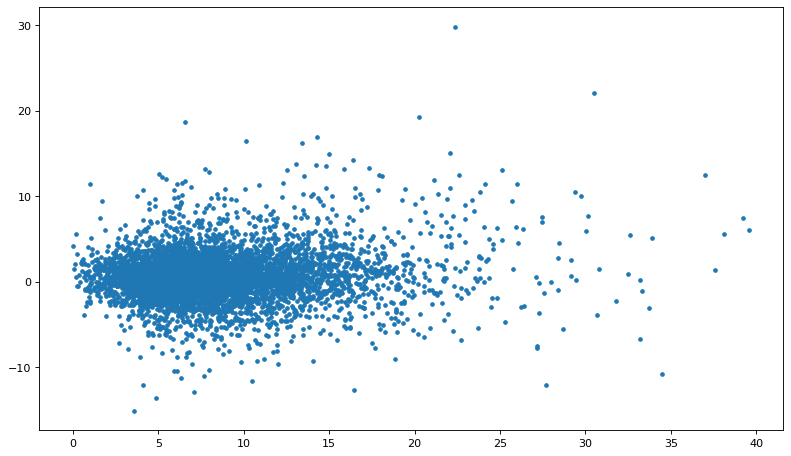

In [16]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [17]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(20)

,year,week,ticker,weekly_delta,weekly_delta_sign,actual_returns,position,GICS Sector,Security
0,2016,4.0,KMI,0.162350,1.0,1.030941,0,Energy,Kinder Morgan
344,2016,4.0,UAA,0.159897,1.0,0.946082,1,Consumer Discretionary,Under Armour (Class A)
688,2016,4.0,TPR,0.133117,1.0,0.969901,2,Consumer Discretionary,"Tapestry, Inc."
1032,2016,4.0,NEM,0.130461,1.0,1.137713,3,Materials,Newmont
1372,2016,4.0,META,0.130167,1.0,0.960031,4,Communication Services,Meta Platforms
1712,2016,4.0,OKE,0.129105,1.0,1.087457,5,Energy,Oneok
2051,2016,4.0,JCI,0.126967,1.0,1.018192,6,Industrials,Johnson Controls
2390,2016,4.0,SLB,0.105355,1.0,0.987126,7,Energy,Schlumberger
2729,2016,4.0,VZ,0.103982,1.0,0.993499,8,Communication Services,Verizon
3067,2016,4.0,SEDG,0.101663,1.0,1.033952,9,Information Technology,SolarEdge


In [18]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [19]:
portfolio

position,year,week,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,2016,4.0,1.030941,0.946082,0.969901,1.137713,0.960031,1.087457,1.018192,0.987126,...,0.952829,1.006310,1.015163,0.990592,0.963286,1.002427,0.969989,0.945825,0.969388,0.962862
1,2016,5.0,1.001397,1.003986,0.992246,0.992941,0.976350,1.006261,0.988925,1.004233,...,1.002270,0.995782,0.997939,0.976241,0.992599,0.992072,1.019913,1.002148,1.003402,0.994236
2,2016,6.0,1.023344,1.014938,1.016026,0.982513,1.085774,1.023201,1.019773,0.986387,...,1.015613,1.003781,0.999862,1.015196,0.998686,0.999372,1.022476,1.009872,0.993463,1.011388
3,2016,7.0,0.985796,1.018165,1.032926,1.020137,0.999182,0.996227,0.989456,1.024920,...,0.986349,1.002905,0.992586,1.019096,1.036891,1.002740,0.969361,1.051216,1.002262,1.001345
4,2016,8.0,1.027283,1.025155,1.022123,1.008091,1.042810,1.003707,1.001466,0.999533,...,1.033033,1.008933,0.997082,1.011619,1.023451,1.002669,0.999404,1.006043,1.013288,1.011628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,2022,48.0,0.995868,1.012216,0.981862,1.044122,1.004347,0.999274,0.988058,1.000043,...,1.014802,1.008103,0.988723,0.999168,0.997199,1.015651,0.999112,1.023843,0.992657,1.012656
340,2022,49.0,0.989698,1.002736,0.985359,0.989891,1.016176,1.021315,1.007533,1.029331,...,0.993362,1.045048,0.993173,1.004016,0.981168,1.011418,1.019785,1.007757,1.021833,1.023056
341,2022,50.0,1.008340,0.972365,0.984506,0.988799,0.995501,0.985589,0.999050,0.981259,...,0.970328,0.975812,0.993261,0.944987,0.974177,1.014652,0.989149,0.989299,0.960084,0.973131
342,2022,51.0,0.918000,1.003804,1.015821,0.995214,1.001354,0.996913,1.006368,1.009723,...,0.998687,1.005530,1.010648,1.004069,1.002169,1.008773,1.011363,1.000955,1.012280,1.023595


In [20]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [21]:
cumulative

,0,1,2,3,4,5,6,7,8,9,year,week,pv,adjclose,bench,date_string,date
0,1.030941,0.946082,0.969901,1.137713,0.960031,1.087457,1.018192,0.987126,0.993499,1.033952,2016,4.0,1.016489,187.73000,1.000000,2016-W4,2016-01-29
1,1.032382,0.949853,0.962380,1.129682,0.937326,1.094266,1.006916,0.991304,0.987736,1.025833,2016,5.0,1.011768,189.76016,1.010814,2016-W5,2016-02-05
2,1.056482,0.964042,0.977803,1.109928,1.017725,1.119654,1.026826,0.977809,0.984451,1.043024,2016,6.0,1.027775,190.93200,1.017056,2016-W6,2016-02-12
3,1.041476,0.981554,1.009998,1.132278,1.016892,1.115429,1.015999,1.002176,0.994173,1.052354,2016,7.0,1.036233,185.12200,0.986108,2016-W7,2016-02-19
4,1.069891,1.006245,1.032342,1.141439,1.060426,1.119564,1.017489,1.001708,1.015405,1.068971,2016,8.0,1.053348,191.68750,1.021081,2016-W8,2016-02-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,61.597486,16.118687,2.806076,12.086166,5.727405,7.334915,4.579567,6.644712,9.876279,9.087562,2022,48.0,13.585885,399.81000,2.129708,2022-W48,2022-12-02
340,60.962920,16.162784,2.764991,11.963989,5.820053,7.491257,4.614065,6.839610,9.883034,9.013680,2022,49.0,13.551638,402.62200,2.144687,2022-W49,2022-12-09
341,61.471368,15.716129,2.722152,11.829980,5.793871,7.383304,4.609683,6.711432,9.643068,8.971941,2022,50.0,13.485293,395.22000,2.105258,2022-W50,2022-12-16
342,56.430740,15.775919,2.765219,11.773357,5.801714,7.360508,4.639036,6.776688,9.849553,9.030846,2022,51.0,13.020358,394.64400,2.102189,2022-W51,2022-12-23


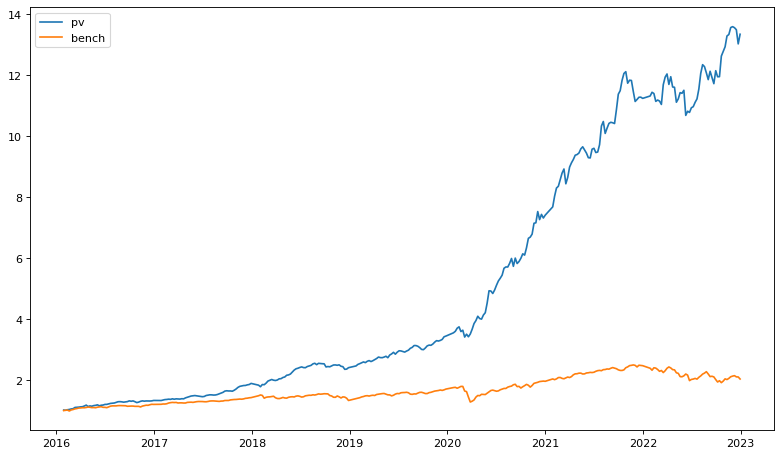

In [22]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [23]:
cumulative

,0,1,2,3,4,5,6,7,8,9,year,week,pv,adjclose,bench,date_string,date
0,1.030941,0.946082,0.969901,1.137713,0.960031,1.087457,1.018192,0.987126,0.993499,1.033952,2016,4.0,1.016489,187.73000,1.000000,2016-W4,2016-01-29
1,1.032382,0.949853,0.962380,1.129682,0.937326,1.094266,1.006916,0.991304,0.987736,1.025833,2016,5.0,1.011768,189.76016,1.010814,2016-W5,2016-02-05
2,1.056482,0.964042,0.977803,1.109928,1.017725,1.119654,1.026826,0.977809,0.984451,1.043024,2016,6.0,1.027775,190.93200,1.017056,2016-W6,2016-02-12
3,1.041476,0.981554,1.009998,1.132278,1.016892,1.115429,1.015999,1.002176,0.994173,1.052354,2016,7.0,1.036233,185.12200,0.986108,2016-W7,2016-02-19
4,1.069891,1.006245,1.032342,1.141439,1.060426,1.119564,1.017489,1.001708,1.015405,1.068971,2016,8.0,1.053348,191.68750,1.021081,2016-W8,2016-02-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,61.597486,16.118687,2.806076,12.086166,5.727405,7.334915,4.579567,6.644712,9.876279,9.087562,2022,48.0,13.585885,399.81000,2.129708,2022-W48,2022-12-02
340,60.962920,16.162784,2.764991,11.963989,5.820053,7.491257,4.614065,6.839610,9.883034,9.013680,2022,49.0,13.551638,402.62200,2.144687,2022-W49,2022-12-09
341,61.471368,15.716129,2.722152,11.829980,5.793871,7.383304,4.609683,6.711432,9.643068,8.971941,2022,50.0,13.485293,395.22000,2.105258,2022-W50,2022-12-16
342,56.430740,15.775919,2.765219,11.773357,5.801714,7.360508,4.639036,6.776688,9.849553,9.030846,2022,51.0,13.020358,394.64400,2.102189,2022-W51,2022-12-23


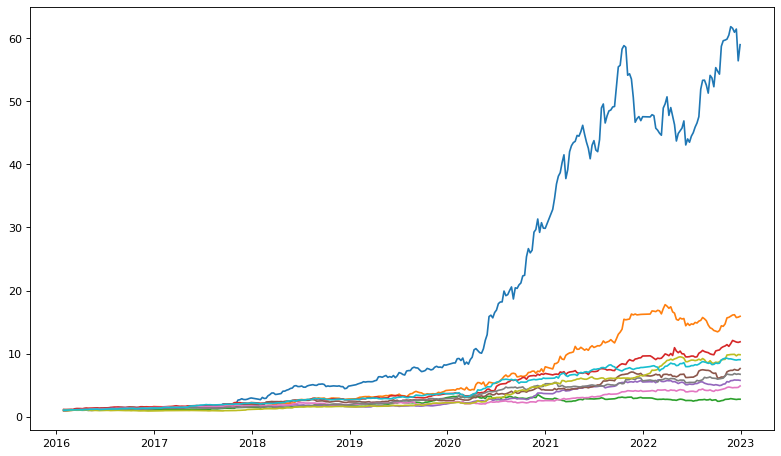

In [24]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)

plt.show()


In [25]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,week,weekly_delta,weekly_delta_sign,actual_returns,position
GICS Sector,,,,,,
Information Technology,2018.870098,27.693627,0.091825,1.0,1.007696,8.726307
Consumer Discretionary,2019.062328,29.965170,0.089144,1.0,1.007513,8.631531
Industrials,2018.908100,26.336449,0.081544,1.0,1.007084,10.017134
Health Care,2019.214286,28.126223,0.082504,1.0,1.006031,9.024462
Materials,2019.038217,27.168790,0.082062,1.0,1.005856,9.754777
Communication Services,2018.977654,26.773743,0.085932,1.0,1.005470,8.935754
Energy,2019.055556,27.224280,0.093309,1.0,1.005018,8.203704
Consumer Staples,2019.065217,28.669082,0.061033,1.0,1.004428,9.985507
Financials,2018.926724,29.325431,0.074090,1.0,1.003818,11.051724


In [26]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

weekly_delta  weekly_delta_sign  \
year week ticker Security                                                    
2017 45.0 ENPH   Enphase                       0.223529                1.0   
2020 23.0 AAL    American Airlines Group       0.304792                1.0   
     16.0 MRNA   Moderna                       0.202382                1.0   
2018 8.0  ENPH   Enphase                       0.065476                1.0   
2020 17.0 PENN   Penn National Gaming          0.142836                1.0   
     27.0 TSLA   Tesla, Inc.                   0.101568                1.0   
     21.0 BBWI   Bath & Body Works, Inc.       0.133970                1.0   
     49.0 OXY    Occidental Petroleum          0.220646                1.0   
     32.0 PENN   Penn National Gaming          0.149656                1.0   
     17.0 MRO    Marathon Oil                  0.163956                1.0   
2016 4.0  NEM    Newmont                       0.130461                1.0   
2018 24.0 ETSY   Etsy                          0.142121                1.0   
     9.0  ENPH   Enphase                       0.148100                1.0   
     6.0  TWTR   Twitter Inc.                  0.173419                1.0   
2020 53.0 ALB    Albemarle Corporation         0.077284                1.0   
     43.0 ALGN   Align Technology              0.158653                1.0   
     22.0 UAL    United Airlines Holdings      0.251110                1.0   
2017 28.0 NRG    NRG Energy                    0.125013                1.0   
2022 17.0 WDC    Western Digital               0.079588                1.0   
          MHK    Mohawk Industries             0.050460                1.0   
2020 21.0 PENN   Penn National Gaming          0.369749                1.0   
     15.0 MRNA   Moderna                       0.179319                1.0   
     23.0 CCL    Carnival                      0.226048                1.0   
     30.0 BBWI   Bath & Body Works, Inc.       0.181054                1.0   
2019 4.0  ALGN   Align Technology              0.135386                1.0   
2021 7.0  AAL    American Airlines Group       0.052216                1.0   
2020 37.0 PENN   Penn National Gaming          0.054740                1.0   
     22.0 KIM    Kimco Realty                  0.211413                1.0   
     4.0  ENPH   Enphase                       0.065443                1.0   
     53.0 ENPH   Enphase                       0.122952                1.0   

                                           actual_returns  position  
year week ticker Security                                            
2017 45.0 ENPH   Enphase                         1.298652         0  
2020 23.0 AAL    American Airlines Group         1.220762         0  
     16.0 MRNA   Moderna                         1.192656         1  
2018 8.0  ENPH   Enphase                         1.186591         5  
2020 17.0 PENN   Penn National Gaming            1.169455        18  
     27.0 TSLA   Tesla, Inc.                     1.164547         3  
     21.0 BBWI   Bath & Body Works, Inc.         1.162184        13  
     49.0 OXY    Occidental Petroleum            1.151261         2  
     32.0 PENN   Penn National Gaming            1.149030         8  
     17.0 MRO    Marathon Oil                    1.142567         9  
2016 4.0  NEM    Newmont                         1.137713         3  
2018 24.0 ETSY   Etsy                            1.136682         1  
     9.0  ENPH   Enphase                         1.134885         0  
     6.0  TWTR   Twitter Inc.                    1.132719         0  
2020 53.0 ALB    Albemarle Corporation           1.131923        11  
     43.0 ALGN   Align Technology                1.131492         0  
     22.0 UAL    United Airlines Holdings        1.130631         2  
2017 28.0 NRG    NRG Energy                      1.130423         0  
2022 17.0 WDC    Western Digital                 1.128036         3  
          MHK    Mohawk Industries               1.125756        17  
2020 2

In [27]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,week,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2016,4.0,0.976765,0.956925,0.962862,1.020485,0.966337,1.000000,1.018192,1.018189,1.137713,1.000000,1.015163
1,4064256,20.0,0.976765,0.956925,0.964468,1.020485,0.962261,0.976241,1.018192,1.018189,1.137713,0.976350,1.013416
2,8193540096,120.0,0.986408,0.956925,0.978041,1.040663,0.981134,0.976241,1.037682,1.073299,1.155239,0.976350,1.008443
3,16518176833536,840.0,0.986408,0.954431,1.010243,1.040663,0.981134,1.012255,1.046188,1.073366,1.184027,0.979186,1.008443
4,33300644496408576,6720.0,1.008230,0.969502,1.011487,1.040663,0.981134,1.029508,1.063566,1.096290,1.216331,0.979186,1.007841
...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,0,inf,1.975912,7.367721,1.974316,3.124868,1.958296,4.954147,4.763242,6.034038,3.804384,1.538010,1.409736
340,0,inf,1.998473,7.335286,2.017421,3.124868,1.973048,5.036951,4.763242,6.162652,3.773455,1.538010,1.418034
341,0,inf,1.998473,7.140196,2.005165,3.124868,1.936072,4.972502,4.833031,5.970585,3.773455,1.538010,1.411562
342,0,inf,2.041266,7.124486,2.009514,3.176925,1.946779,4.954584,4.831299,5.977478,3.773455,1.538010,1.424862
